In [1]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.express as px
from matplotlib import style
style.use('ggplot')
from wordcloud import WordCloud

## Loading the data

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df['word count'] = df['review'].apply(lambda text: len(text.split()))

In [5]:
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


# Data Preprocessing

In [6]:
def data_processing(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [7]:
df.review = df['review'].apply(data_processing)

###### * Here I would like to correct vocabulary with TextBlob. Because I release that in low word frequency, there are several typos, and in TF-IDF, they affect a lot. But it takes several hours, so I choice just stem it.

In [8]:
from tqdm import tqdm, tqdm_pandas
# from textblob import TextBlob
tqdm.pandas()

stemmer = PorterStemmer()
df.review = df['review'].progress_apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

100%|████████████████████████████████████| 50000/50000 [01:18<00:00, 639.05it/s]


In [9]:
df.sentiment.replace("negative", 1, inplace=True)
df.sentiment.replace("positive", 0, inplace=True)

In [10]:
df['word count'] = df['review'].apply(lambda text: len(text.split()))
df

,review,sentiment,word count
0,one review mention watch 1 oz episod hook righ...,0,163
1,wonder littl product film techniqu unassum old...,0,86
2,thought wonder way spend time hot summer weeke...,0,85
3,basic famili littl boy jake think zombi closet...,1,66
4,petter mattei love time money visual stun film...,0,125
...,...,...,...
49995,thought movi right good job creativ origin fir...,0,79
49996,bad plot bad dialogu bad act idiot direct anno...,1,56
49997,cathol taught parochi elementari school nun ta...,1,113
49998,go disagre previou comment side maltin one sec...,1,113


In [11]:
duplicated_count = df.duplicated().sum()
print("Duplicated rows: ", duplicated_count)

df = df.drop_duplicates('review').reset_index()

Duplicated rows:  427


## Analysis the dataset

In [12]:
pos_reviews =  df[df.sentiment == 1]
neg_reviews =  df[df.sentiment == 0]

text = ' '.join([word for word in pos_reviews['review']])
wordcloud_postive = WordCloud(max_words=500, width=1600, height=800).generate(text)
text = ' '.join([word for word in neg_reviews['review']])
wordcloud_negative = WordCloud(max_words=500, width=1600, height=800).generate(text)

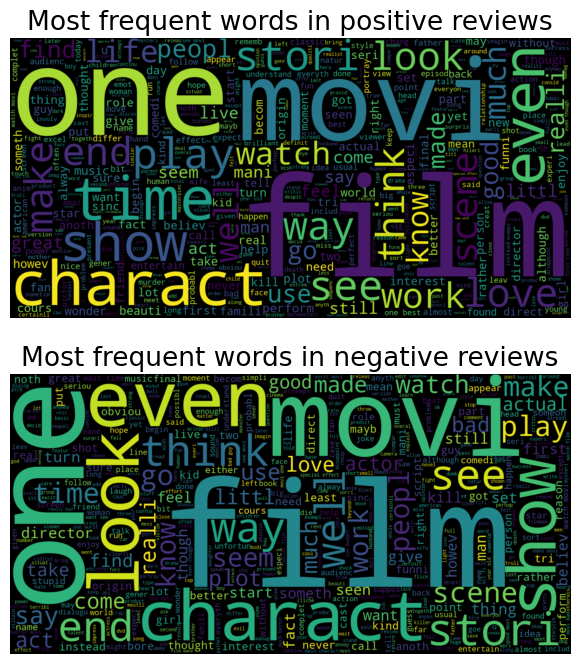

In [ ]:
plt.figure(figsize=(20,8), facecolor='None')
plt.subplot(2,1,1)
plt.imshow(wordcloud_postive, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.subplot(2,1,2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

In [ ]:
from collections import Counter

count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] += 1
pos_words = pd.DataFrame(count.most_common(25))
pos_words.columns = ['word', 'count']

count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] += 1
neg_words = pd.DataFrame(count.most_common(25))
neg_words.columns = ['word', 'count']

# Machine Learning Methods

In [18]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

##### I use TF-IDF to vectorize the data for two kinds of ML method here. LogisticRegrssion and linear SVM.

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
Y = df['sentiment']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.24, random_state=42)

In [27]:
print("Shape of x_train: ", (X_train.shape))
print("Shape of y_train: ", (y_train.shape))
print("Shape of x_test: ", (X_test.shape))
print("Shape of y_test: ", (y_test.shape))

Shape of x_train:  (37675, 73419)
Shape of y_train:  (37675,)
Shape of x_test:  (11898, 73419)
Shape of y_test:  (11898,)


## LogisticRegression

In [24]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 89.20%


In [25]:
print(confusion_matrix(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))

[[5436  538]
 [ 747 5177]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5974
           1       0.91      0.87      0.89      5924

    accuracy                           0.89     11898
   macro avg       0.89      0.89      0.89     11898
weighted avg       0.89      0.89      0.89     11898



## LinearSVC

In [42]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))

Test accuracy: 89.25%


In [43]:
print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred))

[[5406  568]
 [ 711 5213]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5974
           1       0.90      0.88      0.89      5924

    accuracy                           0.89     11898
   macro avg       0.89      0.89      0.89     11898
weighted avg       0.89      0.89      0.89     11898



##### Also, to find better parameters for SVC, I use GridSearcCV to test SVC with different settings.

In [44]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1, 1, 10, 100], 'loss':['hinge', 'squared_hinge']}
grid = GridSearchCV(svc, param_grid, refit=True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................C=0.1, loss=hinge;, score=0.880 total time=   0.1s
[CV 2/5] END .................C=0.1, loss=hinge;, score=0.879 total time=   0.1s
[CV 3/5] END .................C=0.1, loss=hinge;, score=0.882 total time=   0.1s
[CV 4/5] END .................C=0.1, loss=hinge;, score=0.880 total time=   0.1s
[CV 5/5] END .................C=0.1, loss=hinge;, score=0.874 total time=   0.1s
[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.894 total time=   0.1s
[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.889 total time=   0.2s
[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.891 total time=   0.1s
[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.887 total time=   0.1s
[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.884 total time=   0.1s
[CV 1/5] END ...................C=1, loss=hinge;, score=0.894 total time=   1.4s
[CV 2/5] END ...................C=1, loss=hinge;,

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge']},
             verbose=3)

In [45]:
print("best cross validation score: {:.2f}".format(grid.best_score_))
print("best parameters: ", grid.best_params_)

best cross validation score: 0.89
best parameters:  {'C': 1, 'loss': 'hinge'}


In [46]:
svc = LinearSVC(C = 1, loss='hinge')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))

Test accuracy: 89.43%


In [47]:
print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred))

[[5425  549]
 [ 709 5215]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      5974
           1       0.90      0.88      0.89      5924

    accuracy                           0.89     11898
   macro avg       0.89      0.89      0.89     11898
weighted avg       0.89      0.89      0.89     11898



## EXTRA

You can skip this. I use some different neural networks to compare performance. 

In [24]:
Xd_train = X_train[:5000]
yd_train = y_train[:5000]
Xd_test = X_test[:2000]
yd_test = y_test[:2000]

print("Shape of x_train: ", (Xd_train.shape))
print("Shape of y_train: ", (yd_train.shape))
print("Shape of x_test: ", (Xd_test.shape))
print("Shape of y_test: ", (yd_test.shape))

Shape of x_train:  (5000, 73419)
Shape of y_train:  (5000,)
Shape of x_test:  (2000, 73419)
Shape of y_test:  (2000,)


In [90]:
from keras.models import Sequential
from keras.layers import Dense

In [91]:
Xd_train = Xd_train.toarray()
Xd_test = Xd_test.toarray()

In [92]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=Xd_train.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [93]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
history = model.fit(Xd_train, yd_train, batch_size=10, epochs=15)

Epoch 1/15


2023-02-20 00:42:00.904129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 4s 10ms/step - loss: 0.5765 - accuracy: 0.8010
Epoch 2/15
400/400 [==============================] - 4s 11ms/step - loss: 0.2580 - accuracy: 0.9210
Epoch 3/15
400/400 [==============================] - 4s 10ms/step - loss: 0.1410 - accuracy: 0.9550
Epoch 4/15
400/400 [==============================] - 4s 10ms/step - loss: 0.0963 - accuracy: 0.9668
Epoch 5/15
400/400 [==============================] - 4s 10ms/step - loss: 0.0686 - accuracy: 0.9770
Epoch 6/15
400/400 [==============================] - 4s 10ms/step - loss: 0.0538 - accuracy: 0.9820
Epoch 7/15
400/400 [==============================] - 4s 10ms/step - loss: 0.0413 - accuracy: 0.9863
Epoch 8/15
400/400 [==============================] - 4s 11ms/step - loss: 0.0321 - accuracy: 0.9893
Epoch 9/15
400/400 [==============================] - 4s 10ms/step - loss: 0.0253 - accuracy: 0.9928
Epoch 10/15
400/400 [==============================] - 4s 10ms/step - loss: 0.0202 - accuracy: 0.9945


In [95]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                1174720   
                                                                 
 dense_19 (Dense)            (None, 8)                 136       
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,174,865
Trainable params: 1,174,865
Non-trainable params: 0
_________________________________________________________________


In [96]:
test_loss, test_acc = model.evaluate(Xd_test, yd_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

 3/32 [=>............................] - ETA: 0s - loss: 0.6613 - accuracy: 0.8333

2023-02-20 00:43:09.313662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 29ms/step - loss: 0.8815 - accuracy: 0.8290
Test loss: 0.8814504146575928
Test accuracy: 0.8290000557899475


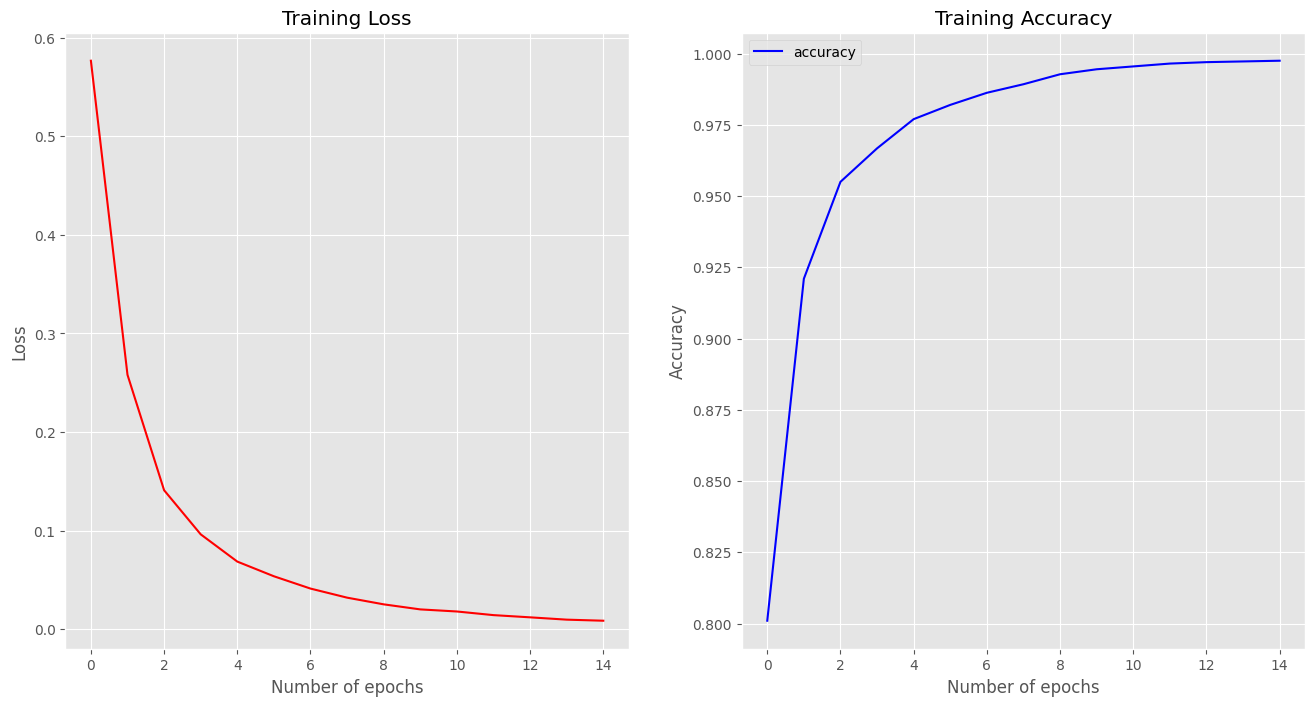

In [97]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r', label='loss')
plt.title('Training Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='b', label='accuracy')
plt.title('Training Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [98]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=Xd_train.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [99]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
history = model.fit(Xd_train, yd_train, batch_size=10, epochs=15)

Epoch 1/15
  6/400 [..............................] - ETA: 4s - loss: 0.6929 - accuracy: 0.5667  

2023-02-20 00:43:22.663024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 4s 9ms/step - loss: 0.5078 - accuracy: 0.8013
Epoch 2/15
400/400 [==============================] - 3s 8ms/step - loss: 0.1289 - accuracy: 0.9650
Epoch 3/15
400/400 [==============================] - 3s 8ms/step - loss: 0.0269 - accuracy: 0.9970
Epoch 4/15
400/400 [==============================] - 3s 9ms/step - loss: 0.0082 - accuracy: 0.9993
Epoch 5/15
400/400 [==============================] - 3s 8ms/step - loss: 0.0033 - accuracy: 0.9998
Epoch 6/15
400/400 [==============================] - 3s 8ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 7/15
400/400 [==============================] - 4s 9ms/step - loss: 9.2085e-04 - accuracy: 1.0000
Epoch 8/15
400/400 [==============================] - 4s 9ms/step - loss: 5.6195e-04 - accuracy: 1.0000
Epoch 9/15
400/400 [==============================] - 4s 9ms/step - loss: 3.6166e-04 - accuracy: 1.0000
Epoch 10/15
400/400 [==============================] - 3s 9ms/step - loss: 2.4414e-04 - accuracy: 1

In [101]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                1174720   
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,174,865
Trainable params: 1,174,865
Non-trainable params: 0
_________________________________________________________________


In [102]:
test_loss, test_acc = model.evaluate(Xd_test, yd_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

 3/32 [=>............................] - ETA: 0s - loss: 0.3982 - accuracy: 0.8750

2023-02-20 00:44:23.690559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 24ms/step - loss: 0.5773 - accuracy: 0.8430
Test loss: 0.5772538185119629
Test accuracy: 0.843000054359436


32/32 [==============================] - 1s 21ms/step - loss: 0.5773 - accuracy: 0.8430
Test loss: 0.5772538185119629


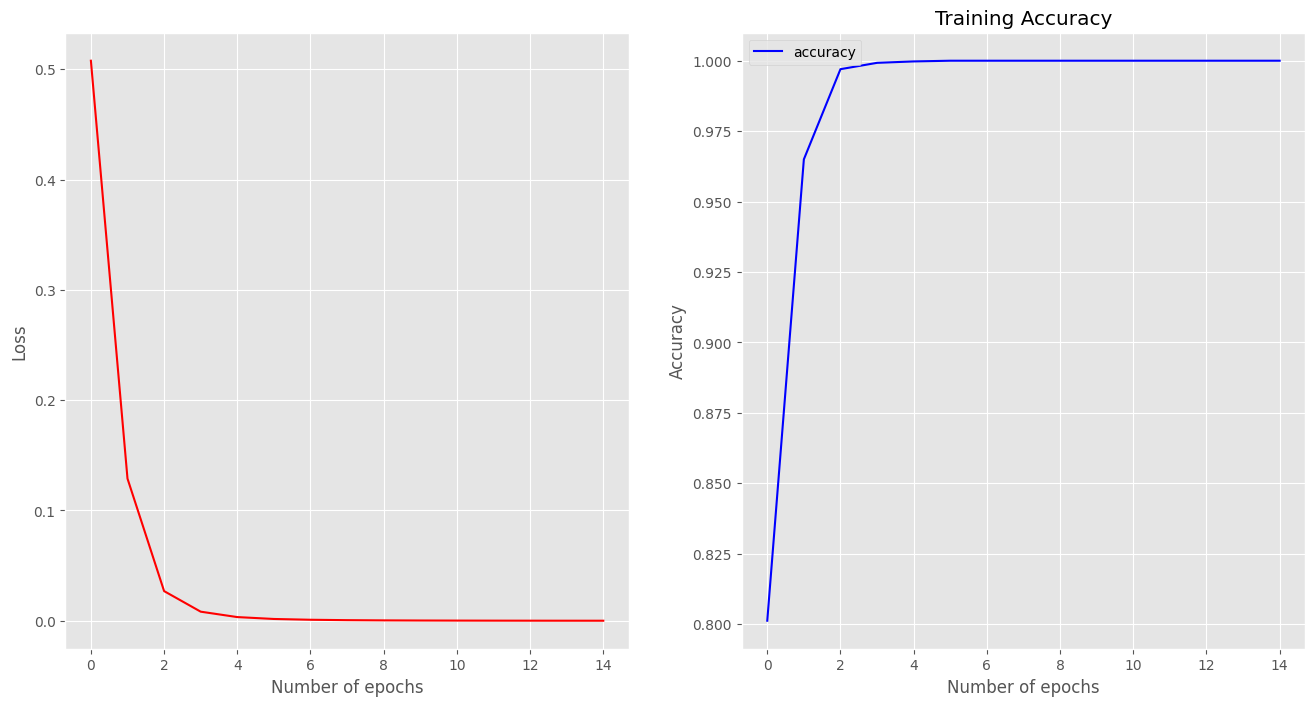

In [103]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r', label='loss')
plt.test_loss, test_acc = model.evaluate(Xd_test, yd_test)
print('Test loss:', test_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='b', label='accuracy')
plt.title('Training Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Thank you in advance For your Time.